In [10]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# missingno: 결측치를 시각화하는 라이브러리입니다.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [11]:
# 데이터 경로 설정 

# (baseline 방식)
data_dir = os.getenv('HOME', '.') + '/aiffel/kaggle_kakr_housing/data'
train_path = os.path.join(data_dir, 'train.csv')
test_path = os.path.join(data_dir, 'test.csv')
sub_path = os.path.join(data_dir, 'sample_submission.csv')
#sub도불러오는이유 : 1.형식맞추기 2. index 맞추기 용도(id가 1부터 시작하는 게 아니라 중간부터 시작하는경우)

# 데이터 불러오기
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_sub = pd.read_csv(sub_path)

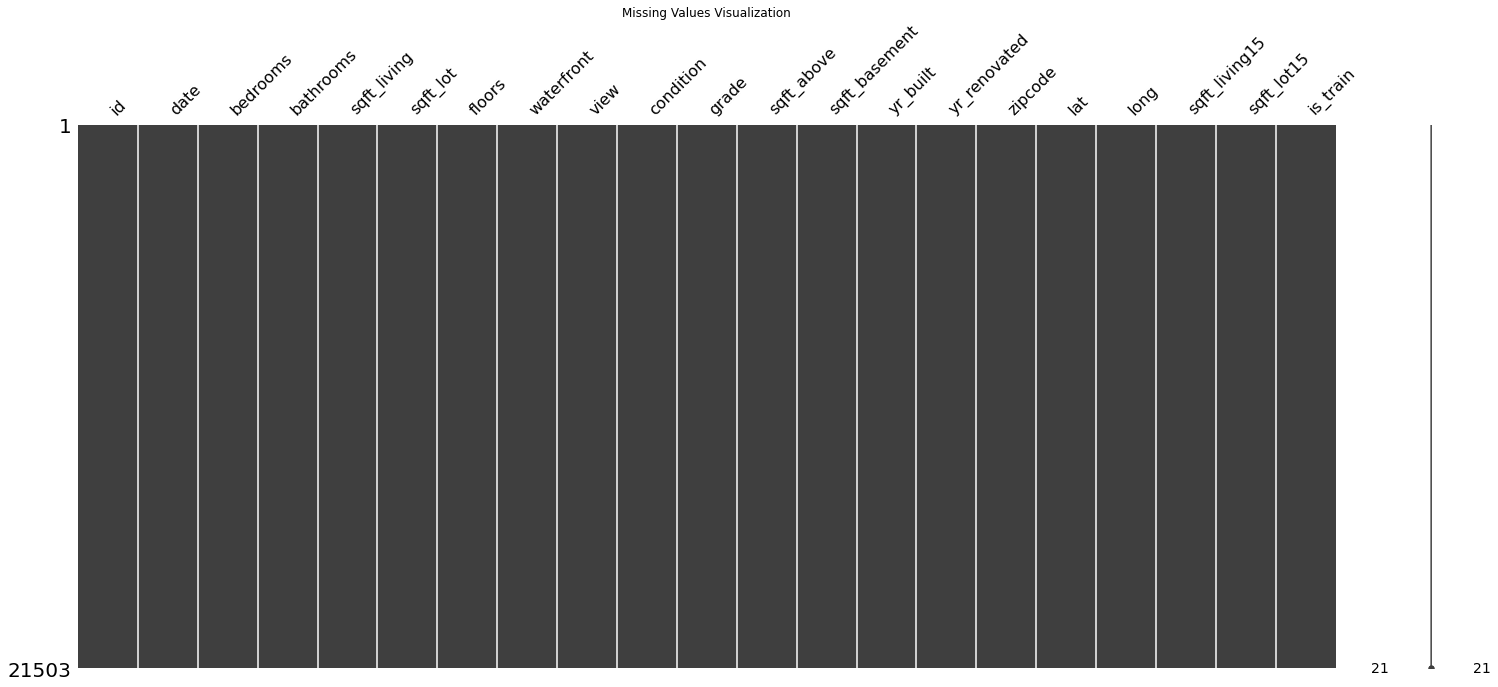

In [12]:
# target 분리
y = np.log1p(df_train['price'])
df_train.drop(columns=['price'], inplace=True)

# train/test 합치기(is_train 열을 추가하여, 학습 데이터와 테스트 데이터를 구별할 수 있게 합니다.)
df_train['is_train'] = 1
df_test['is_train'] = 0
data = pd.concat([df_train, df_test], axis=0)

# EDA - 결측치 시각화
msno.matrix(data)
plt.title("Missing Values Visualization")
plt.show()

In [5]:

# Feature Engineering
# 날짜 정보 처리
if 'date' in data.columns:
    data['date'] = data['date'].apply(lambda x: str(x))
    data['year'] = data['date'].str[:4].astype(int)
    data['month'] = data['date'].str[4:6].astype(int)
    data.drop(columns=['date'], inplace=True)

# 리노베이션 여부 및 주택 경과연수
data['renovated'] = (data['yr_renovated'] != 0).astype(int)
data['age'] = data['yr_built'].max() - data['yr_built']
data.drop(columns=['yr_renovated', 'yr_built'], inplace=True)

# 로그 변환
for col in ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15']:
    data[col] = np.log1p(data[col])

# 필요없는 열 제거
if 'id' in data.columns:
    data.drop(columns=['id'], inplace=True)

In [6]:
# train/test 다시 분리
X = data[data['is_train'] == 1].drop(columns=['is_train'])
X_test = data[data['is_train'] == 0].drop(columns=['is_train'])

# 학습/검증 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 평가 함수 정의
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# 모델 + 파라미터
models = {
    "RandomForest": (RandomForestRegressor(random_state=42), {
        'n_estimators': [100], 'max_depth': [10, None]
    }),
    "XGBoost": (XGBRegressor(objective='reg:squarederror', random_state=42), {
        'n_estimators': [100], 'max_depth': [3, 6], 'learning_rate': [0.05, 0.1]
    }),
    "LightGBM": (LGBMRegressor(random_state=42), {
        'n_estimators': [100], 'num_leaves': [31, 50], 'learning_rate': [0.05, 0.1]
    })
}

best_model = None
best_score = float('inf')





In [7]:
# 모델별 학습 및 검증
for name, (model, params) in models.items():
    print(f"\n▶ {name} 모델 학습 중...")
    grid = GridSearchCV(model, params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    pred = grid.predict(X_val)
    score = rmsle(np.expm1(y_val), np.expm1(pred))
    print(f"{name} RMSLE: {score:.5f} | Best Params: {grid.best_params_}")

    if score < best_score:
        best_score = score
        best_model = grid.best_estimator_
        best_name = name

# 최종 모델 전체 학습
best_model.fit(X, y)
test_pred = np.expm1(best_model.predict(X_test))

# 결과 저장
submission = pd.read_csv(sub_path)
submission['price'] = test_pred
filename = f'submission_{best_name}_RMSLE_{best_score:.6f}.csv'
submission.to_csv(filename, index=False)
print(f"\n✅ 최종 결과 저장 완료: {filename}")


▶ RandomForest 모델 학습 중...
RandomForest RMSLE: 0.18052 | Best Params: {'max_depth': None, 'n_estimators': 100}

▶ XGBoost 모델 학습 중...


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


XGBoost RMSLE: 0.16947 | Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}

▶ LightGBM 모델 학습 중...
LightGBM RMSLE: 0.16635 | Best Params: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 50}

✅ 최종 결과 저장 완료: submission_LightGBM_RMSLE_0.166348.csv


In [8]:
#주요 구성

#EDA 시각화 포함: missingno, seaborn 사용

#피처 엔지니어링: 로그변환, 날짜 처리, 리노베이션 여부, 경과연수 등

#모델 3종: RandomForest, XGBoost, LightGBM 전부 학습 + GridSearchCV 튜닝

#성능 평가: RMSLE 기준으로 비교, 가장 좋은 모델 자동 선택

#제출 파일 생성: submission_{모델명}_RMSLE_{점수}.csv 형태로 저장